In [ ]:
%reset

#VGG16 on ₹500 note dataset

#Importing the photos and creating the dataset

Dataset Shape - (7020, 224, 224, 3)
Sample Image -



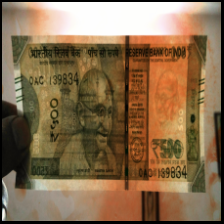

In [13]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

def generateDataset():
    trainingInput = []
    trainingOutput = []
    noOfRows = 224
    noOfCols = 224

    label = 1
    inputArray = False
    drive_loc = "/content/drive/My Drive/Colab Notebooks/Fake Notes/"
    
    for directory in ['500/Real Notes 500/', '500/Duplicate Notes 500/']:
        for filename in os.listdir(drive_loc + directory):
            img = cv2.imread(drive_loc + directory + filename)
            img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
            
            # TRANSLATIONS
            # will produce (6 + 6 + 1) x (6 + 6 + 1) = 169 images
            # stride of 5 pixels along both axis along all 4 directions
            for x in range(30, -35, -5):
                for y in range(30, -35, -5):
                    translationMatrix = np.float32([ [1,0,x], [0,1,y] ])
                    imgTrns = cv2.warpAffine(img, translationMatrix, (noOfCols, noOfRows))
                    trainingInput.append((imgTrns))
                    trainingOutput.append(label)

            # ROTATIONS
            # we produce 41 different angles in the range of -10 to 10
            # with the step being equal to 0.5
            for angle in range(20, -21, -1):
                rotationMatrix = cv2.getRotationMatrix2D((noOfCols/2, noOfRows/2), float(angle)/2, 1)
                imgRotated = cv2.warpAffine(img, rotationMatrix, (noOfCols, noOfRows))
                trainingInput.append((imgRotated))
                trainingOutput.append(label)

            # PROJECTIVE TRANSFORMATIONS for ZOOMING IN AND ZOOMING OUT
            # will produce (30 + 30) images for the dataset
            # 1ST ZOOMING IN ...
            for step in np.arange(0.001, 0.031, 0.001):
                srcPoints = np.float32([[int(step*(noOfCols-1)),int(step*(noOfRows-1))], [int((1-step)*(noOfCols-1)),int(step*(noOfRows-1))], [int(step*(noOfCols-1)),int((1-step)*(noOfRows-1))], [int((1-step)*(noOfCols-1)), int((1-step)*(noOfRows-1))]])
                dstPoints = np.float32([[0,0], [noOfCols-1,0], [0,noOfRows-1], [noOfCols-1,noOfRows-1]]) 
                projective_matrix = cv2.getPerspectiveTransform(srcPoints, dstPoints)
                imgZoomed = cv2.warpPerspective(img, projective_matrix, (noOfCols,noOfRows))
                trainingInput.append((imgZoomed))
                trainingOutput.append(label)
            # 2ND ZOOMING OUT ...
            for step in np.arange(0.001, 0.031, 0.001):
                srcPoints = np.float32(np.float32([[0,0], [noOfCols-1,0], [0,noOfRows-1], [noOfCols-1,noOfRows-1]]))
                dstPoints = np.float32([[int(step*(noOfCols-1)),int(step*(noOfRows-1))], [int((1-step)*(noOfCols-1)),int(step*(noOfRows-1))], [int(step*(noOfCols-1)),int((1-step)*(noOfRows-1))], [int((1-step)*(noOfCols-1)), int((1-step)*(noOfRows-1))]]) 
                projective_matrix = cv2.getPerspectiveTransform(srcPoints, dstPoints)
                imgZoomed = cv2.warpPerspective(img, projective_matrix, (noOfCols,noOfRows))
                trainingInput.append((imgZoomed))
                trainingOutput.append(label)

        # set label for fake images to come
        label = 0
       
    return trainingInput, trainingOutput

X, y = generateDataset()
X = np.array(X).reshape(len(X), 224, 224, 3)
y = np.array(y).astype('int32')
print("Dataset Shape -", X.shape)
print("Sample Image -\n")
cv2_imshow(X[1600])


#Splitting the dataset into test and validation data

In [14]:
import sklearn.model_selection
from keras.utils import to_categorical

y = to_categorical(y)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=69)

#Implementing the VGG16 CNN Architecture

In [15]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model

input_img = Input(shape=(224,224,3))

layer = Conv2D(64, 3, padding="same", activation="relu")(input_img)
layer = Conv2D(64, 3, padding="same", activation="relu")(layer)
layer = MaxPooling2D(pool_size=(2,2), strides=(2,2))(layer)

layer = Conv2D(128, 3, padding="same", activation="relu")(layer)
layer = Conv2D(128, 3, padding="same", activation="relu")(layer)
layer = MaxPooling2D(pool_size=(2,2), strides=(2,2))(layer)

layer = Conv2D(256, 3, padding="same", activation="relu")(layer)
layer = Conv2D(256, 3, padding="same", activation="relu")(layer)
layer = Conv2D(256, 3, padding="same", activation="relu")(layer)
layer = MaxPooling2D(pool_size=(2,2), strides=(2,2))(layer)

layer = Conv2D(512, 3, padding="same", activation="relu")(layer)
layer = Conv2D(512, 3, padding="same", activation="relu")(layer)
layer = Conv2D(512, 3, padding="same", activation="relu")(layer)
layer = MaxPooling2D(pool_size=(2,2), strides=(2,2))(layer)

layer = Conv2D(512, 3, padding="same", activation="relu")(layer)
layer = Conv2D(512, 3, padding="same", activation="relu")(layer)
layer = Conv2D(512, 3, padding="same", activation="relu")(layer)
layer = MaxPooling2D(pool_size=(2,2), strides=(2,2))(layer)

flattened = Flatten()(layer)

layer = Dense(4096, activation="relu")(flattened)
layer = Dropout(0.2)(layer)
layer = Dense(4096, activation="relu")(layer)
layer = Dropout(0.2)(layer)

output = Dense(2, activation="softmax")(layer)

classifier = Model(input_img, output)
classifier.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 128)      

#Running the model and plotting the results

Epoch 1/10
189/189 [==============================] - 96s 507ms/step - loss: 0.7061 - accuracy: 0.5110 - val_loss: 0.7019 - val_accuracy: 0.5015
Epoch 2/10
189/189 [==============================] - 96s 508ms/step - loss: 0.6932 - accuracy: 0.5433 - val_loss: 0.6837 - val_accuracy: 0.5650
Epoch 3/10
189/189 [==============================] - 96s 508ms/step - loss: 0.6868 - accuracy: 0.5545 - val_loss: 0.7030 - val_accuracy: 0.5498
Epoch 4/10
189/189 [==============================] - 96s 508ms/step - loss: 0.6842 - accuracy: 0.5522 - val_loss: 0.6785 - val_accuracy: 0.5654
Epoch 5/10
189/189 [==============================] - 96s 508ms/step - loss: 0.6751 - accuracy: 0.5811 - val_loss: 0.6742 - val_accuracy: 0.5844
Epoch 6/10
189/189 [==============================] - 96s 508ms/step - loss: 0.6654 - accuracy: 0.5932 - val_loss: 0.6549 - val_accuracy: 0.6599
Epoch 7/10
189/189 [==============================] - 96s 508ms/step - loss: 0.6433 - accuracy: 0.6296 - val_loss: 0.6290 - val_ac

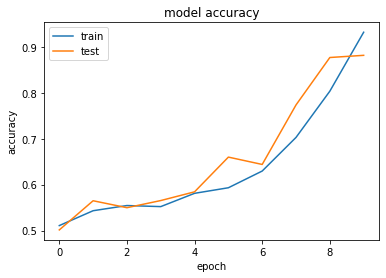

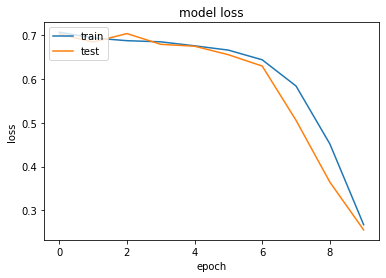

In [16]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt

classifier.compile(optimizer=Adam(lr=0.000001), loss=categorical_crossentropy, metrics=['accuracy'])

history = classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=25, verbose=1, shuffle=True)

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()